# **Brain Segmentation Model**
Developed by: [**Ashutosh Shukla**](https://www.linkedin.com/in/ashutosh-shukla4/)
## **Overview**
This notebook demonstrates a complete pipeline for converting 3D brain scans (from the Task01_BrainTumour dataset) into 2D top-view images using maximum intensity projection (MIP) and then training a 2D U-Net segmentation model with MONAI (v1.4.0), and finally performing inference on test images with automatic annotation of different brain regions. The regions are labeled with anatomical names (e.g., Grey Matter, White Matter, Hippocampus) according to a pre-defined mapping.
*   Due to low computational power, I converted the original 3D brain scans into 2D images. This significantly reduces the data complexity and computational requirements, enabling faster processing and model training.
* The conversion was done using **NiBabel** to load NIfTI files, and a **Maximum Intensity Projection (MIP)** along the Z-axis was applied to extract a top view of the brain.
* I chose the top view because it provides a clear overview of the brain's structure while reducing the data dimensionality.




## **1. Dependencies and Environment Setup**
Let us begin by installing the required packages:

MONAI v1.4.0: A deep learning framework specifically for medical imaging.
nibabel: For reading NIfTI files.
opencv-python: For image processing and visualization.
PyTorch: For building and training the model.

In [ ]:
!pip install monai==1.4.0 nibabel opencv-python

In [ ]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
import torch.optim as optim
print("MONAI version:", __import__("monai").__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MONAI version: 1.4.0


### Mounting Google Drive to access the dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **2. Setting up Directory Structure and Data Paths**
* Data Paths:
The training (imagesTr, labelsTr) and testing (imagesTs) directories are defined.

* 2D Conversion Directories:
Separate directories are created for the converted 2D images and labels.

In [ ]:
DATA_ROOT = "/content/drive/MyDrive/BrainSegmentation/Task01_BrainTumour"
train_images_dir = os.path.join(DATA_ROOT, "imagesTr")
train_labels_dir = os.path.join(DATA_ROOT, "labelsTr")
test_images_dir  = os.path.join(DATA_ROOT, "imagesTs")  # For later inference

# Directory to store 2D images
two_d_data_dir = os.path.join(DATA_ROOT, "2D_data")
os.makedirs(two_d_data_dir, exist_ok=True)
images_2d_dir = os.path.join(two_d_data_dir, "images2D")
labels_2d_dir = os.path.join(two_d_data_dir, "labels2D")
os.makedirs(images_2d_dir, exist_ok=True)
os.makedirs(labels_2d_dir, exist_ok=True)

# Directory for 2D testing images
images_2d_test_dir = os.path.join(two_d_data_dir, "images2D_test")
os.makedirs(images_2d_test_dir, exist_ok=True)

print("Training Images:", train_images_dir)
print("Training Labels:", train_labels_dir)
print("Testing Images:", test_images_dir)
print("2D Training images will be in:", images_2d_dir)
print("2D Training labels will be in:", labels_2d_dir)
print("2D Testing images will be in:", images_2d_test_dir)


Training Images: /content/drive/MyDrive/BrainSegmentation/Task01_BrainTumour/imagesTr
Training Labels: /content/drive/MyDrive/BrainSegmentation/Task01_BrainTumour/labelsTr
Testing Images: /content/drive/MyDrive/BrainSegmentation/Task01_BrainTumour/imagesTs
2D Training images will be in: /content/drive/MyDrive/BrainSegmentation/Task01_BrainTumour/2D_data/images2D
2D Training labels will be in: /content/drive/MyDrive/BrainSegmentation/Task01_BrainTumour/2D_data/labels2D
2D Testing images will be in: /content/drive/MyDrive/BrainSegmentation/Task01_BrainTumour/2D_data/images2D_test


## **3. Converting 3D Volumes to 2D Top-View Images**
* Method:
Maximum intensity projection (MIP) is applied along the Z-axis to obtain a 2D image from each 3D volume.



In [ ]:
image_files = sorted(glob.glob(os.path.join(train_images_dir, "*.nii.gz")))
label_files = sorted(glob.glob(os.path.join(train_labels_dir, "*.nii.gz")))


In [ ]:
def max_intensity_projection(volume_3d):
    return np.max(volume_3d, axis=2)  # (X, Y, Z) -> (X, Y)

* Conversion of Training Data:

In [ ]:

def max_intensity_projection(volume_3d):
    return np.max(volume_3d, axis=2)  # (X, Y, Z) -> (X, Y)

for img_path, lbl_path in zip(image_files, label_files):
    subject_id = os.path.basename(img_path).replace(".nii.gz", "")
    img_3d = nib.load(img_path).get_fdata()
    lbl_3d = nib.load(lbl_path).get_fdata()

    img_2d = max_intensity_projection(img_3d)
    lbl_2d = max_intensity_projection(lbl_3d)

    # Normalize image
    img_2d_norm = (img_2d - img_2d.min()) / (img_2d.max() - img_2d.min() + 1e-8)
    lbl_2d_int = lbl_2d.astype(np.uint8)

    img_2d_filename = os.path.join(images_2d_dir, f"{subject_id}_2D.png")
    lbl_2d_filename = os.path.join(labels_2d_dir, f"{subject_id}_2D_label.png")

    cv2.imwrite(img_2d_filename, (img_2d_norm*255).astype(np.uint8))
    cv2.imwrite(lbl_2d_filename, lbl_2d_int)


KeyboardInterrupt: 

* Conversion of Testing Data:

In [ ]:
test_image_files = sorted(glob.glob(os.path.join(test_images_dir, "*.nii.gz")))
for img_path in test_image_files:
    subject_id = os.path.basename(img_path).replace(".nii.gz", "")
    img_3d = nib.load(img_path).get_fdata()
    if img_3d.ndim > 3:
        img_3d = img_3d[..., 0]
    img_2d = max_intensity_projection(img_3d)
    img_2d_norm = (img_2d - img_2d.min()) / (img_2d.max() - img_2d.min() + 1e-8)
    img_2d_filename = os.path.join(images_2d_test_dir, f"{subject_id}_2D.png")
    cv2.imwrite(img_2d_filename, (img_2d_norm*255).astype(np.uint8))
    print(f"{subject_id} conversion done (testing)")

## **4. Building Data Dictionaries**
* Training Data Dictionary:

In [ ]:
two_d_image_files = sorted(glob.glob(os.path.join(images_2d_dir, "*.png")))
two_d_label_files = sorted(glob.glob(os.path.join(labels_2d_dir, "*_label.png")))
data_dicts = [{"image": img, "label": lbl} for img, lbl in zip(two_d_image_files, two_d_label_files)]
print(f"Found {len(data_dicts)} training 2D image-label pairs.")


Found 484 training 2D image-label pairs.


* Testing Data Dictionary:

In [ ]:
test_two_d_image_files = sorted(glob.glob(os.path.join(images_2d_test_dir, "*.png")))
test_data_dicts = [{"image": img} for img in test_two_d_image_files]  # no labels for test
print(f"Found {len(test_data_dicts)} testing 2D images.")


Found 266 testing 2D images.


## **5. Define Transforms and DataLoaders**
### **Training and Testing Transforms**
* LoadImaged: Loads images and labels from file paths.
* LambdaD: Converts images to grayscale (if needed) and adds a channel dimension.
* ScaleIntensityd: Normalizes the image intensity.
* Resized: Resizes images and labels to 256×256.
* RandRotateD: Applies random rotation augmentation.
* ToTensord: Converts the arrays into PyTorch tensors.
### **Training Transforms**

In [ ]:
from monai.transforms import Compose, LoadImaged, LambdaD, ScaleIntensityd, Resized, RandRotateD, ToTensord
import numpy as np

# Define the transform pipeline for dictionary-based data.
transforms_2d = Compose([
    LoadImaged(keys=["image", "label"]),
    # Convert the image to grayscale if it's not already 2D:
    LambdaD(keys=["image"], func=lambda x: x if x.ndim == 2 else np.mean(x, axis=2)),
    # Manually add a channel dimension to image and label if they are 2D.
    LambdaD(keys=["image", "label"], func=lambda x: np.expand_dims(x, axis=0) if x.ndim == 2 else x),
    ScaleIntensityd(keys=["image"]),
    Resized(keys=["image", "label"], spatial_size=(256, 256)),
    RandRotateD(keys=["image", "label"], range_x=15, prob=0.3),
    ToTensord(keys=["image", "label"]),
])

dataset_2d = CacheDataset(data=data_dicts, transform=transforms_2d, cache_rate=1.0)
loader_2d = DataLoader(dataset_2d, batch_size=2, shuffle=True, num_workers=2)
print("2D DataLoader for training is ready.")

Loading dataset: 100%|██████████| 484/484 [02:06<00:00,  3.84it/s]

2D DataLoader for training is ready.


### **Testing Transforms**

In [ ]:
from monai.transforms import Compose, LoadImaged, LambdaD, ScaleIntensityd, Resized, RandRotateD, ToTensord

transforms_2d = Compose([
    LoadImaged(keys=["image", "label"]),
    # Convert image to grayscale if needed.
    LambdaD(keys=["image"], func=lambda x: x if x.ndim == 2 else np.mean(x, axis=2)),
    # Add channel dimension to both image and label.
    LambdaD(keys=["image", "label"], func=lambda x: np.expand_dims(x, axis=0) if x.ndim == 2 else x),
    ScaleIntensityd(keys=["image"]),
    Resized(keys=["image", "label"], spatial_size=(256, 256)),
    RandRotateD(keys=["image", "label"], range_x=15, prob=0.3),
    ToTensord(keys=["image", "label"]),
])

dataset_2d = CacheDataset(data=data_dicts, transform=transforms_2d, cache_rate=1.0)
loader_2d = DataLoader(dataset_2d, batch_size=2, shuffle=True, num_workers=2)
print("2D DataLoader for testing is ready.")

Loading dataset: 100%|██████████| 484/484 [00:14<00:00, 33.62it/s]

2D DataLoader for testing is ready.


## **6. Define the 2D U-Net Model, Loss, and Optimizer**
* Model Configuration:
The 2D U-Net is defined for images with 1 channel and outputs 4 classes. DiceLoss is used for segmentation, and the Adam optimizer is applied.

In [ ]:
model_2d = UNet(
    spatial_dims=2,       # 2D U-Net
    in_channels=1,        # Grayscale input
    out_channels=4,       # Number of segmentation classes (adjust as needed)
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function_2d = DiceLoss(to_onehot_y=True, softmax=True)
optimizer_2d = optim.Adam(model_2d.parameters(), lr=1e-4)


## **7. Training Loop**
* Training Process:
The model is trained for 10 epochs, processing each batch from the training DataLoader, computing the Dice loss, and updating model parameters.

In [ ]:
num_epochs = 10
model_2d.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_data in loader_2d:
        inputs = batch_data["image"].to(device)    # Expected shape: [B, 1, 256, 256]
        labels = batch_data["label"].to(device)      # Expected shape: [B, 1, 256, 256]

        optimizer_2d.zero_grad()
        outputs = model_2d(inputs)                   # [B, out_channels, 256, 256]
        loss = loss_function_2d(outputs, labels)
        loss.backward()
        optimizer_2d.step()

        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(loader_2d)
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")

Epoch [1/10] Avg Loss: 0.8267
Epoch [2/10] Avg Loss: 0.7744
Epoch [3/10] Avg Loss: 0.7427
Epoch [4/10] Avg Loss: 0.7138
Epoch [5/10] Avg Loss: 0.6880
Epoch [6/10] Avg Loss: 0.6623
Epoch [7/10] Avg Loss: 0.6470
Epoch [8/10] Avg Loss: 0.6304
Epoch [9/10] Avg Loss: 0.6184
Epoch [10/10] Avg Loss: 0.6118


## **8. Inference and Automatic Region Annotation on Testing Data**
### **Automatic Annotation:**

* Model Prediction:
The trained model takes test image and produces segmentation mask—an array where each pixel is assigned a numeric label corresponding to a brain region.

* Mapping Numbers to Names:
I used a predefined dictionary (called region_names) to translate these numbers into human-readable labels (e.g., 1 = "Grey Matter", 2 = "White Matter", 3 = "Hippocampus").

* Extracting and Drawing Contours:
The code identifies the boundaries (*contours*) of each region in the segmentation mask—similar to drawing an outline around shapes on a page.

* Overlay and Annotation:
These contours are then drawn on the original image in distinct colors, and the region names are added as text at the center of each outlined area.

Showing 2 outputs from many others for reference:


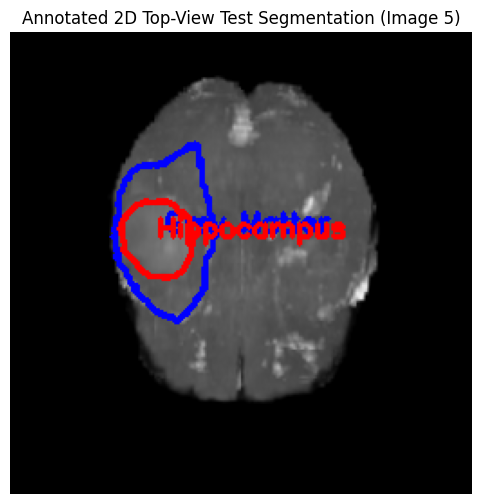

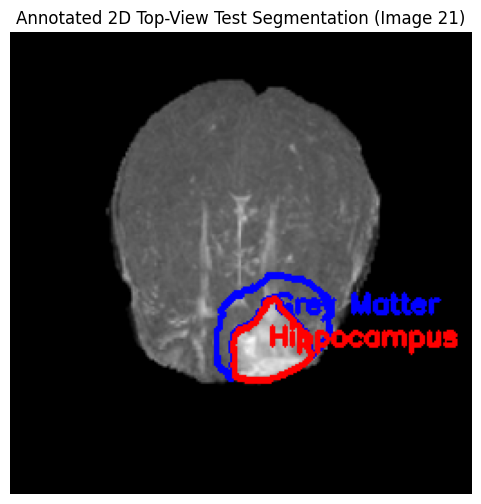

In [ ]:
region_names = {
    1: "Grey Matter",
    2: "White Matter",
    3: "Hippocampus"
}

model_2d.eval()
results = []

# Iterate with one-indexing.
for i, batch in enumerate(test_loader_2d, start=1):
    # Process only images 5 and 9.
    if i not in {5, 21}:
        continue

    with torch.no_grad():
        input_image = batch["image"].to(device)  # [1, 1, 256, 256]
        output = model_2d(input_image)           # [1, out_channels, 256, 256]
        pred_mask = torch.argmax(output, dim=1).cpu().numpy()[0]  # [256, 256]

    # Load the original test image from file, if available.
    test_img_path = batch["image_meta_dict"]["filename_or_obj"] if (
        "image_meta_dict" in batch and "filename_or_obj" in batch["image_meta_dict"]
    ) else None
    if test_img_path is not None:
        orig_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
        if orig_img is None:
            orig_img = batch["image"].cpu().numpy().squeeze()
        else:
            orig_img = cv2.resize(orig_img, (256, 256))
    else:
        orig_img = batch["image"].cpu().numpy().squeeze()

    # Convert the original image to 3-channel BGR for overlay.
    if orig_img.ndim == 2:
        orig_rgb = cv2.cvtColor(orig_img, cv2.COLOR_GRAY2BGR)
    else:
        orig_rgb = orig_img.copy()

    overlayed = orig_rgb.copy()
    unique_classes = np.unique(pred_mask)

    for cls in unique_classes:
        if cls == 0:
            continue  # Skip background.
        class_mask = (pred_mask == cls).astype(np.uint8) * 255
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        label_text = region_names.get(cls, f"Region {cls}")
        # Define a simple color mapping.
        color_options = {
            1: (255, 0, 0),
            2: (0, 255, 0),
            3: (0, 0, 255)
        }
        color_bgr = color_options.get(cls, (128, 128, 128))

        for contour in contours:
            if cv2.contourArea(contour) < 50:
                continue
            cv2.drawContours(overlayed, [contour], -1, color_bgr, thickness=2)
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = contour[0][0]
            cv2.putText(overlayed, label_text, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 2)

    results.append(overlayed)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
    plt.title(f"Annotated 2D Top-View Test Segmentation (Image {i})")
    plt.axis("off")
    plt.show()




This project demonstrates an end-to-end pipeline for brain segmentation using 2D representations derived from 3D datasets. Due to current computational constraints, I converted the original 3D brain scans into 2D top-view images using a maximum intensity projection (MIP) method. This helped me for efficient training and testing with a 2D U-Net model, enabling rapid experimentation and meaningful segmentation of critical brain regions such as Grey Matter, White Matter, and Hippocampus.

Future Work:
With access to more robust computational resources, future work will extend this pipeline to directly handle full 3D datasets. This would involve:

* Leveraging 3D U-Net Architectures: Training and fine-tuning 3D segmentation models to capture volumetric context and complex spatial relationships inherent in brain scans.
* Advanced Data Augmentation & Preprocessing: Applying sophisticated augmentation techniques and improved normalization methods tailored for 3D medical images.
* Uncertainty Quantification: Integrating statistical analysis tools for uncertainty estimation, which can enhance diagnostic confidence.
* Atlas-Based Segmentation: Utilizing brain atlases to improve the anatomical labeling accuracy and enable more detailed region-specific analysis.

#### Building this have greatly enhanced my understanding of medical image analysis and deep learning, and I look forward to further exploring these challenges with improved computational power and resources in the future.

#### Please do let me know about your reviews and feedbacks.
### Connect with me on [**LinkedIn**](https://www.linkedin.com/in/ashutosh-shukla4/)

